[[이유한님] 캐글 코리아 캐글 스터디 커널 커리큘럼](https://kaggle-kr.tistory.com/32)  
[타이타닉 캐글 링크](https://www.kaggle.com/c/titanic)

# [Titanic Top 4% with ensemble modeling](https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling)  
__Yassine Ghouzam, PhD__  
  
13/07/2017  
  
- __1 Introduction__
- __2 Load and check data__
    - 2.1 load data
    - 2.2 Outlier detection
    - 2.3 joining train and test set
    - 2.4 check for null and missing values
- __3 Feature analysis__
    - 3.1 Numerical values
    - 3.2 Categorical values
- __4 Filling missing Values__
    - 4.1 Age
- __5 Feature engineering__
    - 5.1 Name/Title
    - 5.2 Family Size
    - 5.3 Cabin
    - 5.4 Ticket
- __6 Modeling__
    - 6.1 Simple modeling
        - 6.1.1 Cross validate models
        - 6.1.2 Hyperparamater tunning for best models
        - 6.1.3 Plot learning curves
        - 6.1.4 Feature importance of the tree based classifiers
    - 6.2 Ensemble modeling
        - 6.2.1 Combining models
    - 6.3 Prediction
        - 6.3.1 Predict and Submit results

# 1. Introduction
This is my first kernel at Kaggle. I choosed the Titanic competition which is a good way to introduce feature engineering and ensemble modeling. Firstly, I will display some feature analyses then ill focus on the feature engineering. Last part concerns modeling and predicting the survival on the Titanic using an voting procedure.  
  
This script follows three main parts:  
  
- __Feature analysis__
- __Feature engineering__
- __Modeling__

# DeepL 번역
이것은 Kaggle에서의 첫 번째 커널입니다. 저는 피처 엔지니어링과 앙상블 모델링을 소개하기 좋은 타이타닉 대회를 선택했습니다. 먼저 몇 가지 특징 분석을 보여준 다음 특징 엔지니어링에 대해 집중적으로 설명하겠습니다. 마지막 부분은 투표 절차를 사용하여 타이타닉의 생존율을 모델링하고 예측하는 것입니다.  
  
이 스크립트는 크게 세 부분으로 구성됩니다:  
  
- __특징 분석__
- __기능 엔지니어링__
- __모델링__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# get_ipython().run_line_magic('matplotlib', 'inline')

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis    #  LDA(선형 판별 분석): 정규분포와 서로 같은 공분산 구조를 가정한 군집 분류
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis # QDA(이차 판별 분석): 서로 다른 공분산 구조를 가정한 군집 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

# sns.set(style='white', context='notebook', palette='deep')

import warnings
warnings.filterwarnings('ignore')

# 2. Load and check data
## 2.1 Load data

In [2]:
# Load data
##### Load train and Test set

train = pd.read_csv('./input/001_titanic/train.csv')
test = pd.read_csv('./input/001_titanic/test.csv')
IDtest = test['PassengerId']

## 2.2 Outlier detection

In [3]:
# Outlier detection
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1-outlier_step) | (df[col] > Q3+outlier_step)].index

        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v>n)

    return multiple_outliers

# detect outliers from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

Since outliers can have a dramatic effect on the prediction (espacially for regression problems), i choosed to manage them.  
  
I used the Tukey method (Tukey JW., 1977) to detect ouliers which defines an interquartile range comprised between the 1st and 3rd quartile of the distribution values (IQR). An outlier is a row that have a feature value outside the (IQR +- an outlier step).  
  
I decided to detect outliers from the numerical values features (Age, SibSp, Sarch and Fare). Then, i considered outliers as rows that have at least two outlied numerical values.  
  
__DeepL 번역__  
이상값은 예측에 큰 영향을 미칠 수 있으므로(특히 회귀 문제의 경우) 이상값을 관리하기로 결정했습니다.  
  
저는 분포 값의 1사분위수에서 3사분위수 사이로 구성된 사분위수 간 범위(IQR)를 정의하는 Tukey 방법(Tukey JW., 1977)을 사용하여 이상값을 감지했습니다. 이상값은 (IQR +- an outlier step)을 벗어나는 특징값을 가진 행입니다.  
  
저는 숫자 값 특징(Age, SibSp, Sarch 및 Fare)에서 이상값을 감지하기로 결정했습니다. 그런 다음 이상값이 두 개 이상 있는 행을 이상값으로 간주했습니다.

In [4]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [5]:
# We detect 10 outliers. The 28, 89 and 342 passenger have an high Ticket Fare
# The 7 others have very high values of SibSP.

# Drop outliers

train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

## 2.3 joining train and test set

In [6]:
## Join train and test datasets in order to obtain the same number of features during categoricla conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

# I join train and test datasets to obtain the same number of features during categorical conversion
# (See feature engineering).

## 2.4 check for null and missing values

In [7]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age and Cabin features have an important part of missing values.  
  
__Survived missing values correspond to the join testing dataset (Survived column doesn't exist in test set and has been replace by NaN values when concatenating the train and test set)__

In [8]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
### Summarize data
# Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3.Feature analysis
## 3.1 Numerical values

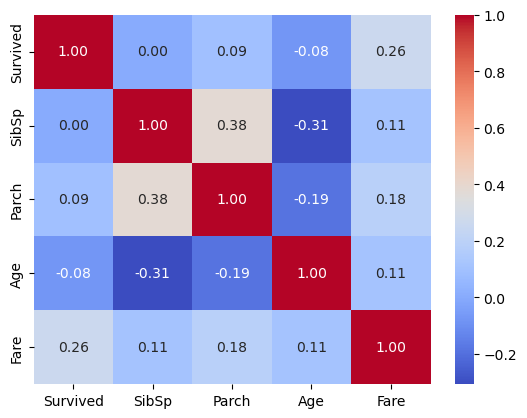

In [12]:
# Correlation matrix beween numerical values (SibSp Parch Age and Fare values) and Survived

g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

Only Fare feature seems to have a significative correlation with the survival probability.
  
It doesn't mean that the other features are not usefull. Subpopulations in these features can be correlated with the survival. To determine this, we need to explore in detail these features  
  
__SibSP__

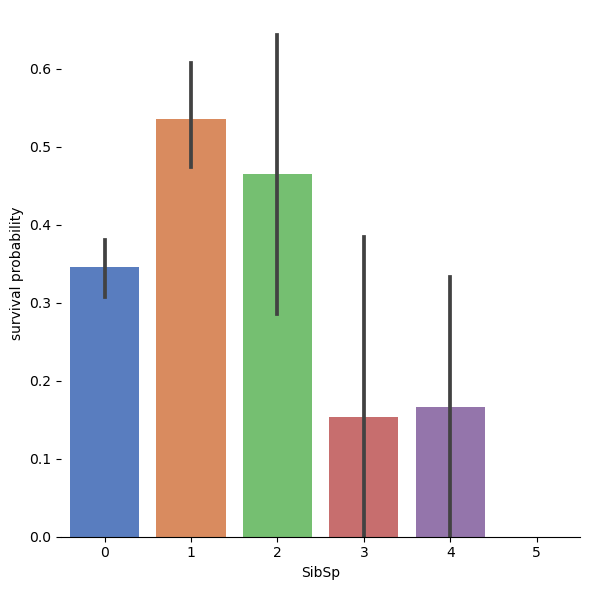

In [13]:
# Explore SibSp feature vs Survived

# g = sns.factorplot(x='SibSp', y='Survived', data=train, kind='bar', size=6, palette='muted')
# 함수 변경
g = sns.catplot(x='SibSp', y='Survived', data=train, kind='bar', height=6, palette='muted')
g.despine(left=True)    # 그래프 외곽선? 제거 설정
g = g.set_ylabels('survival probability')

It seems that passengers having a lot of siblings/spouses have less chance to survive  
  
Single passengers (0 SibSP) or with two other persons (SibSP 1 or 2) have more chance to survive  
  
This observation is quite interesting, we can consider a new feature describing these categories (See feature engineering)  
  
__Parch__

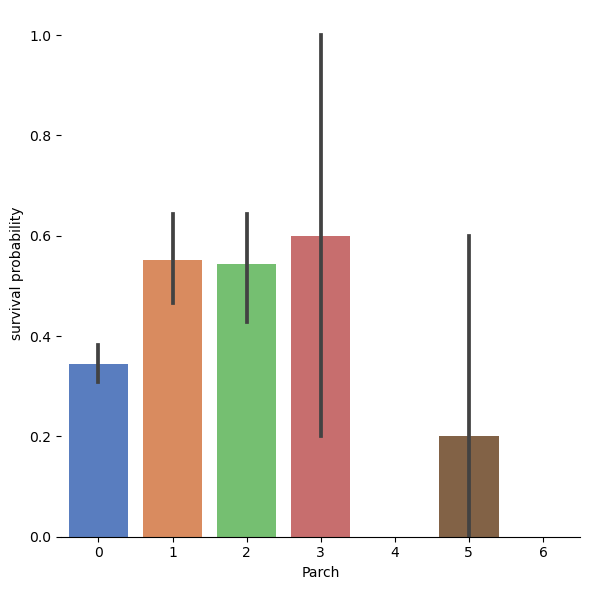

In [14]:
# Explore Parch feature vs Survived

# g = sns.factorplot(x='Parch', y='Survived', data=train, kind='bar', size=6, palette='muted')
# 함수 변경
g = sns.catplot(x='Parch', y='Survived', data=train, kind='bar', height=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

Small families have more chance to survive, more than single (Parch 0), medium (Parch 3,4) and large families (Parch 5,6 ).  
  
Be carefull there is an important standard deviation in the survival of passengers with 3 parents/children  
  
__Age__

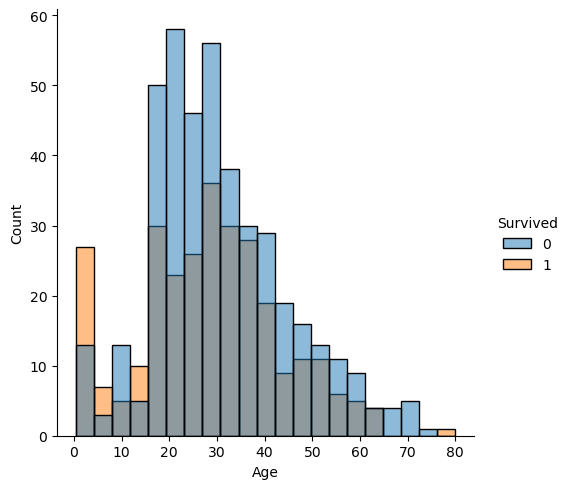

In [15]:
sns.displot(data=train, x='Age', hue='Survived');

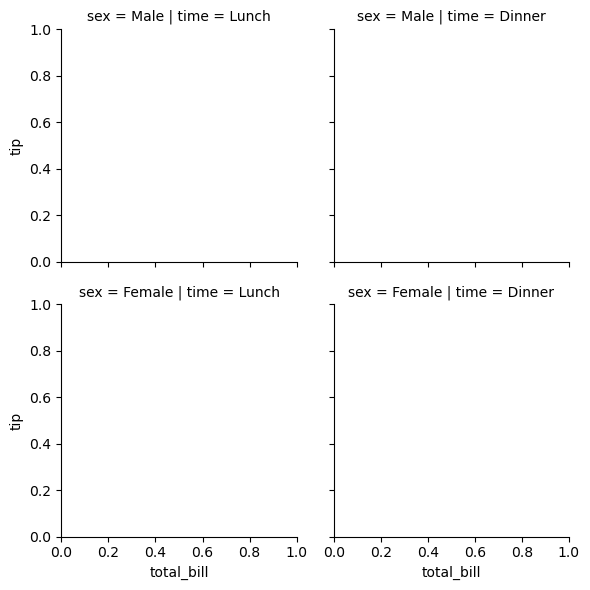

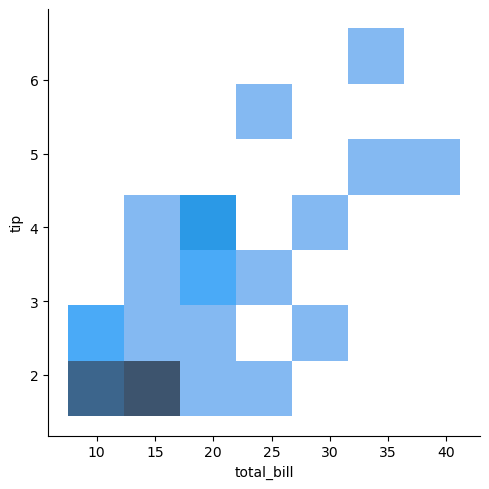

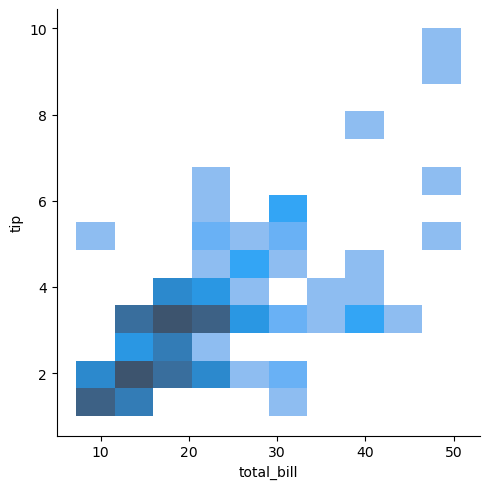

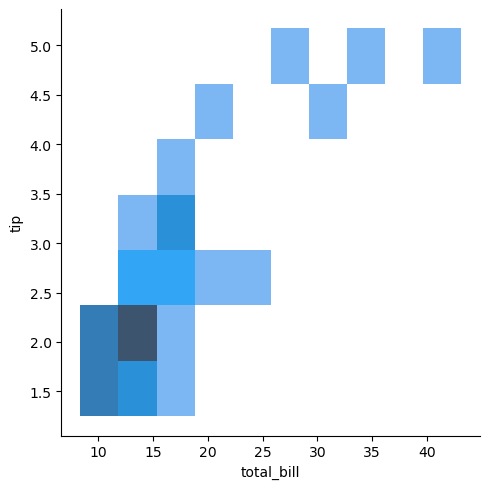

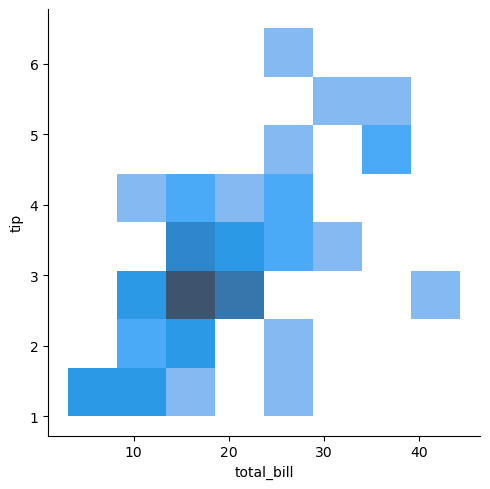

In [16]:
tips = sns.load_dataset("tips")
g = sns.FacetGrid(tips, col="time",  row="sex")
g.map(sns.displot, "total_bill", "tip");

In [17]:
data = {'Class': [0, 1, 1, 1, 1, 0, 1, 0, 1],
        'count': [509, 61, 18, 29, 8, 148, 54, 361, 46],
        'greek_char': ['Alpha', 'Alpha', 'Alpha', 'Alpha', 'Beta', 'Beta', 'Beta', 'Beta', 'Beta'],
        'value': ['A', 'B', 'D', 'G', 'A', 'B', 'B', 'C', 'C']}

df = pd.DataFrame(data)
df

,Class,count,greek_char,value
0,0,509,Alpha,A
1,1,61,Alpha,B
2,1,18,Alpha,D
3,1,29,Alpha,G
4,1,8,Beta,A
5,0,148,Beta,B
6,1,54,Beta,B
7,0,361,Beta,C
8,1,46,Beta,C


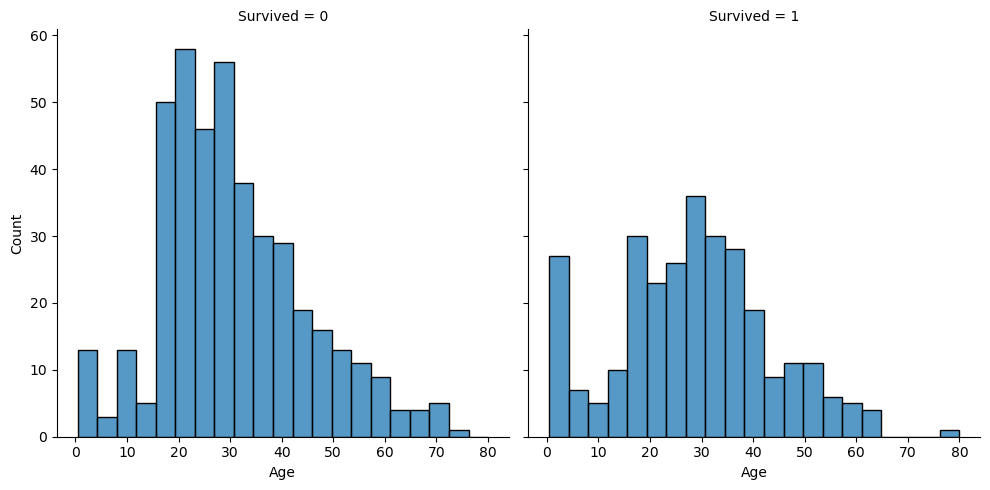

In [18]:
# Explore Age vs Survived
# g = sns.FacetGrid(train, col='Survived')    # Multi-plot grid for plotting conditional relationships.
# g = g.map(sns.displot, 'Age')               # displot가 FacetGrid에 그려지지 않아서 아래 코드로 대체
g = sns.displot(data=train, x='Age', col='Survived');

Age distribution seems to be a tailed distribution, maybe a gaussian distribution.  
  
We notice that age distributions are not the same in the survived and not survived subpopulations. Indeed, there is a peak corresponding to young passengers, that have survived. We also see that passengers between 60-80 have less survived.  
  
So, even if "Age" is not correlated with "Survived", we can see that there is age categories of passengers that of have more or less chance to survive.  
  
It seems that very young passengers have more chance to survive.  
  
__DeepL 번역__  
연령 분포가 꼬리 분포, 즉 가우스 분포인 것 같습니다.  
  
생존한 하위 집단과 생존하지 않은 하위 집단에서 연령 분포가 동일하지 않다는 것을 알 수 있습니다. 실제로 생존한 젊은 승객에 해당하는 정점이 있습니다. 또한 60~80세 사이의 승객은 생존자 수가 적다는 것을 알 수 있습니다.  
  
따라서 '나이'가 '생존'과 상관관계가 없더라도 생존 확률이 높거나 낮은 연령대의 승객이 있다는 것을 알 수 있습니다.  
  
아주 젊은 승객이 생존할 확률이 더 높은 것으로 보입니다.  

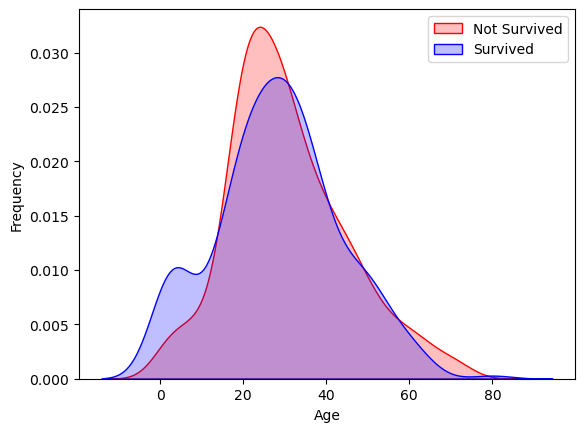

In [19]:
# Explore Age distribution

g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1) & (train['Age'].notnull())], color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

When we superimpose the two densities , we cleary see a peak correponsing (between 0 and 5) to babies and very young childrens.  
  
__Fare__

In [20]:
dataset['Fare'].isnull().sum()

1

In [21]:
# Fill Fare missing values with median value
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

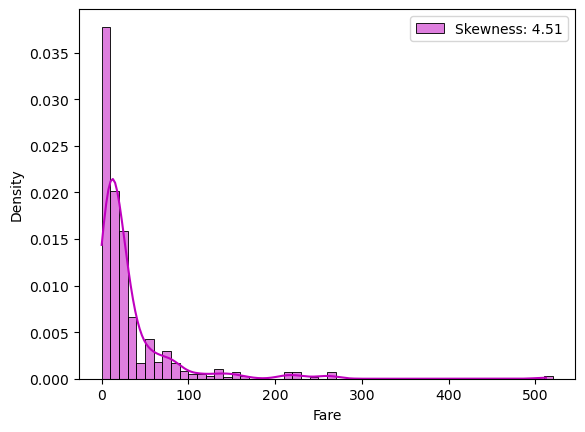

In [22]:
# Since we have one missing value, 
# I decided to fill it with the median value which will not have an important effect on the prediction.

# Explore Fare distribution
# g = sns.distplot(dataset['Fare'], color='m', label='Skewness: %.2f' %dataset['Fare'].skew())
# g = g.legend(loc='best')

# 상기 sns.distplot은 제거 예정으로 아래의 코드 사용
g = sns.histplot(dataset['Fare'], stat='density', color='m', label='Skewness: %.2f' %dataset['Fare'].skew(), kde=True, binwidth=10)
# pd.[DataFrame|Series].skew(): 왜도(skew) 산출, pd.[DataFrame|Series].kurtosis(): 첨도(kurtosis) 산출
g = g.legend(loc='best')

As we can see, Fare distribution is very skewed. This can lead to overweigth very high values in the model, even if it is scaled.  
  
In this case, it is better to transform it with the log function to reduce this skew.

In [23]:
# Apply log to Fare to reduce skewness distribution
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i>0 else 0)

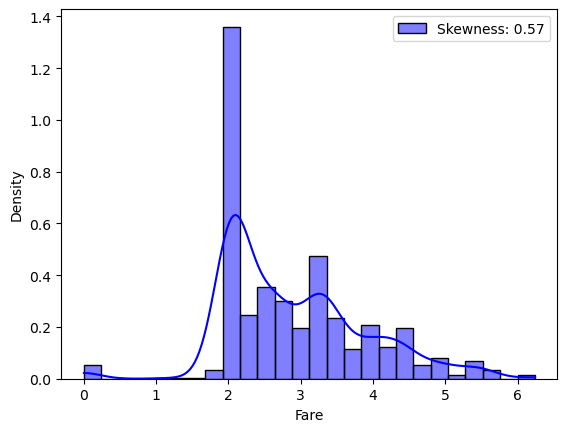

In [24]:
# g = sns.distplot(dataset['Fare'], color='b', label='Skewness: %.2f'%(dataset['Fare'].skew()))
# g = g.legend(loc='best')

# 상기 sns.distplot은 제거 예정으로 아래의 코드 사용
g = sns.histplot(dataset['Fare'], stat='density', color='b', label='Skewness: %.2f' %dataset['Fare'].skew(), kde=True, bins=26)
g = g.legend(loc='best')

Skewness is clearly reduced after the log transformation  
  
## 3.2 Categorical values
__sex__

https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling